<a href="https://colab.research.google.com/github/Arpit1371/HousePricePrediction_MachineLearning/blob/main/ELL409_Assn3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


In [ ]:
def plot(category,train_results):
    plt.plot(train_results.history[category])
    plt.plot(train_results.history['val_'+category])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.title(category)
    plt.show()

In [ ]:
class network:
    # A class to implement a generic neural network
    # Layers list represents the layers of the model, including the input and the output layer
    # Activations, initializers similarly represent the activation functions and the
    # initializers for the layers. The activation by default is 'relu'
    # Dropout is a list of lists such that each value represents the layers where dropout
    # to be added and the dropout rate
    # normalization represents the kind of normalization to be used
    def __init__(self, layer = [], activations = [], initializers = []\
                 ,loss = 'binary_crossentropy', dropout = []\
                 ,normalization = 'minmax', imp_dim = 10, **kwargs):
        self.layers = layer
        self.activations = activations
        self.initializers = initializers
        self.loss = loss
        self.normalization = normalization
        self.model = tf.keras.Sequential()
        c = 0
        for i in range(0,len(layer)):
            activ = activations[i] if i < len(activations) else 'relu'
            index, rate = dropout[c] if c < len(dropout) else [0,1.0]
            if i == 0:
                self.model.add(tf.keras.layers.Dense(units=layer[i]\
                                                     ,activation=activ\
                                                     ,use_bias=True\
                                                     ,kernel_initializer=initializers[i]\
                                                     ,bias_initializer='zeros'\
                                                     ,kernel_regularizer=tf.keras.regularizers.L1(0.001)\
                                                     ,input_shape = (imp_dim,)))
            elif i == len(layer)-1:
                self.model.add(tf.keras.layers.Dense(units=layer[i]\
                                                     ,activation=activ,kernel_regularizer=tf.keras.regularizers.L1(0.001)))
            else:
                self.model.add(tf.keras.layers.Dense(units=layer[i]\
                                                     ,activation=activ\
                                                     ,use_bias=True\
                                                     ,kernel_initializer=initializers[i]\
                                                     ,bias_initializer='zeros'\
                                                     ,kernel_regularizer=tf.keras.regularizers.L1(0.001)))

            if index == i+1:
                self.model.add(tf.keras.layers.Dropout(rate))
                c += 1

    def normalize(self,data):
        X = data[0]
        Y = data[1]
        norm_X = X
        if self.normalization == 'minmax':
            norm_X = preprocessing.MinMaxScaler().fit_transform(X)
        elif self.normalization == 'standard':
            norm_X = preprocessing.StandardScaler().fit_transform(X)
        elif self.normalization == 'maxabs':
            norm_X = preprocessing.MaxAbsScaler().fit_transform(X)
        return [norm_X,Y]




In [ ]:
def evaluate(data = [], val_split = 0, test_train_split = 0.6\
               ,lr = 0.1, momentum = 0.0, num_epochs = 20\
               ,batch_size = 16, optimizer = 'Adam', num_folds = 5, layer = []\
             ,activations = [], initializers = [],loss = 'binary_crossentropy', dropout = []\
                 ,normalization = 'minmax', imp_dim = 10, decay = 0.0, decay_type = 'exponential', **kwargs):
      net = network(layers,activations,initializers, normalization=normalization,dropout=dropout)
      if net.normalization != 'none':
          data = net.normalize(data)
      x_train,x_test,y_train,y_test = train_test_split(data[0],data[1],test_size=test_train_split,random_state=42)
        #train = self.model.fit(x_train, y_train, batch_size=batch_size\
        #                       ,epochs=num_epochs, validation_split=val_split)
      callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
      kfolds = KFold(n_splits=num_folds, shuffle = True)
      cross_val = 0
      for trainset, valset in kfolds.split(x_train,y_train):
          net = network(layers,activations,initializers, normalization = normalization)
          if decay > 0.0 and decay_type == 'exponential':
            lr1 = tf.keras.optimizers.schedules.ExponentialDecay(lr,decay_steps=1000,decay_rate=decay,staircase=True)
          elif decay > 0.0 and decay_type == 'polynomial':
            lr1 = tf.keras.optimizers.schedules.PolynomialDecay(lr,decay_steps=1000,power=decay,end_learning_rate=0.0001)
          if optimizer == 'SGD':
              net.model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=lr1, momentum=momentum)\
                           ,loss=loss, metrics=['accuracy'])
          elif optimizer == 'Adam':
              net.model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr1)\
                           ,loss=loss, metrics=['accuracy'])
          train = net.model.fit(x_train[trainset], y_train[trainset]\
                               , batch_size=batch_size,epochs=num_epochs, callbacks = [callback], verbose= 0)
          val = net.model.evaluate(x_train[valset], y_train[valset])
            #print(val)
          cross_val += val[1]
      cross_val = cross_val/num_folds
      net = network(layers,activations,initializers, normalization = normalization)
      if decay > 0.0 and decay_type == 'exponential':
        lr = tf.keras.optimizers.schedules.ExponentialDecay(lr,decay_steps=1000,decay_rate=decay,staircase=True)
      elif decay > 0.0 and decay_type == 'polynomial':
        lr = tf.keras.optimizers.schedules.PolynomialDecay(lr,decay_steps=1000,power=decay,end_learning_rate=0.0001)
      if optimizer == 'SGD':
          net.model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=lr,momentum=momentum)\
                         ,loss=loss, metrics=['accuracy'])
      elif optimizer == 'Adam':
          net.model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr)\
                           ,loss=loss, metrics=['accuracy'])
      train = net.model.fit(x_train, y_train, batch_size=batch_size\
                           ,epochs=num_epochs, validation_split=val_split, callbacks = [callback], verbose=0)
      plot('accuracy',train)
      plot('loss',train)
      print('Cross validation is - ',cross_val)
      net.model.evaluate(x_test, y_test)
      return net.model.predict(x_test), y_test

8/8 [==============================] - 0s 2ms/step - loss: 0.5370 - accuracy: 0.9013


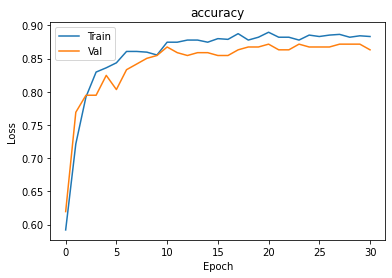

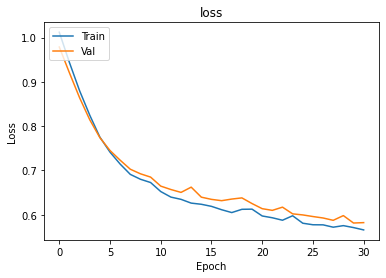

Cross validation is -  0.8853086829185486
10/10 [==============================] - 0s 2ms/step


In [ ]:
layers = [32,32,1]
activations = ['relu', 'relu', 'sigmoid']
initializers = ['he_normal', 'he_normal']
dropout = [[2,0.3]]
#dropout = []
df = pd.read_csv("housepricedata.csv")
dataset = df.values
val_split = 0.20
test_split = 0.20
lr = 0.005
epochs = 150
batch_size = 32
data1 = []
data1.append(dataset[:,0:10])
data1.append(dataset[:,10])
y_res,y_inp = evaluate(data=data1,val_split=val_split,test_train_split=test_split,lr=lr\
         ,num_epochs=epochs,batch_size=batch_size,layer=layers,activations=activations\
         ,initializers=initializers, optimizer="SGD", momentum=0.9, decay=0.2\
         , decay_type='exponential', dropout=dropout)


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_res2 = y_res > 0.5

In [ ]:
y_res2

array([[False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [ ]:
c_mat = confusion_matrix(y_inp, y_res2)

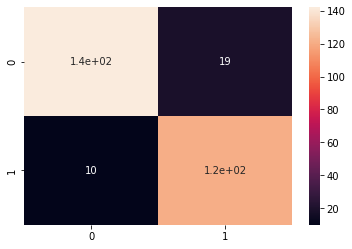

In [ ]:
import seaborn as sns
sns.heatmap(c_mat, annot=True)